<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_1_LatentSpace_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The provided code defines and utilizes an Autoencoder neural network for the MNIST dataset. Here's a detailed explanation:

- **Autoencoder Class**: This class creates a neural network with encoder and decoder components. The encoder compresses the input image into a lower-dimensional latent space, and the decoder reconstructs the image from this latent space. The network is structured to flatten and process 28x28 grayscale MNIST images.

- **Data Loading**: Utilizes PyTorch's DataLoader to efficiently load the MNIST dataset, applying transformations to normalize the images.

- **Training Loop**: Iterates over the training dataset, feeding batches of images through the model, calculating the reconstruction loss, and updating the model's weights to minimize this loss, effectively learning to compress and reconstruct the input images.

- **Visualization**: After training, the script visualizes a batch of original images and their reconstructions from the autoencoder. It also prints the latent space representations, showcasing what the model has learned to encode.

- **Utility Functions**: Includes `imshow` for displaying tensors as images. It unnormalizes the data and uses Matplotlib to plot them.

This script encapsulates the end-to-end process of training an autoencoder on the MNIST dataset, visualizing the results, and examining the learned latent space.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
from torch.cuda.amp import GradScaler, autocast

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder: compresses the image into a lower-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Flatten the image and then linearly transform it
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(128, encoding_dim),  # Linear transformation to the encoding dimension
            nn.ReLU(True)  # Non-linear activation function
        )
        # Decoder: reconstructs the image from the latent space
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Linearly transforms the encoding
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(128, 28 * 28),  # Transforms back to original image shape
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 28*28))  # Encode the input image
        x = self.decoder(x)  # Decode the encoded image
        return x.view(-1, 1, 28, 28)  # Reshape to the original image dimensions

In [ ]:

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert the tensor to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Reshape and display the image
    plt.show()

In [ ]:
# Transform: converts images to PyTorch tensors and normalizes them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# MNIST dataset loading
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(encoding_dim=64).to(device)
criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizer

In [ ]:
# Training loop
num_epochs = 10
scaler = GradScaler()

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        with autocast():
            output = model(img)
            loss = criterion(output, img)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))




Epoch [1/10], Loss:0.9331
Epoch [2/10], Loss:0.9275
Epoch [3/10], Loss:0.9337
Epoch [4/10], Loss:0.9248
Epoch [5/10], Loss:0.9287
Epoch [6/10], Loss:0.9207
Epoch [7/10], Loss:0.9269
Epoch [8/10], Loss:0.9246
Epoch [9/10], Loss:0.9296
Epoch [10/10], Loss:0.9230


Original Images


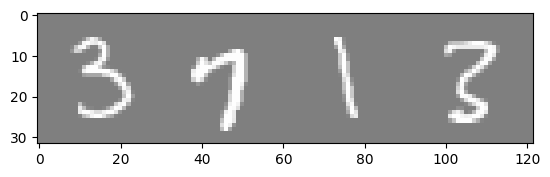

Original Representation
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1.

In [ ]:
# Visualization of the original and reconstructed images
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Display original images
print("Original Images")
imshow(vutils.make_grid(images[:4], normalize=True))

# Encoded and decoded images
with torch.no_grad():
    encoded_imgs = model.encoder(images.view(-1, 28*28)[:4])
    decoded_imgs = model.decoder(encoded_imgs).view(-1, 1, 28, 28)

# Display reconstructed images
#print("Reconstructed Images")
#imshow(vutils.make_grid(decoded_imgs, normalize=True))

# Display reconstructed images
print("Original Representation")
print(img)

# Print latent space
print("Latent space representations:")
print(encoded_imgs)